In [2]:
model_path = "/home/wbm001/deeplpi/DeepLPI/output/model/v9b3-davisreg-e950.pth.tar"
test_path = "/home/wbm001/deeplpi/data/davis/testset.csv"
plot_path = "/home/wbm001/deeplpi/DeepLPI/output/plot/DeepLPI_6165_Reg_Davis/"

molembed_path = "/home/wbm001/deeplpi/data/davis/mol.csv"
seqembed_path = "/home/wbm001/deeplpi/data/davis/seq_6165.csv"

RAMDOMSEED = 11
CLASSIFYBOUND = -2

In [3]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
import torch

In [6]:
class resBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_conv1=False, strides=1, dropout=0.3):
        super().__init__()
        
        self.process = nn.Sequential (
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels)
        )
        
        if use_conv1:
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv1 = None
        
    def forward(self, x):
        left = self.process(x)
        right = x if self.conv1 is None else self.conv1(x)
        
        return F.relu(left + right)

class cnnModule(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel=32, dropout=0.3, headpooling=False):
        super().__init__()

        self.head = nn.Sequential (
            nn.Conv1d(in_channel, hidden_channel, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(hidden_channel),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(5, stride=3) if headpooling == True else nn.MaxPool1d(2)
        )
        
        self.cnn = nn.Sequential (
            resBlock(hidden_channel, out_channel, use_conv1=True, strides=1),
            resBlock(out_channel, out_channel, strides=1),
            resBlock(out_channel, out_channel, strides=1),
        )
    
    def forward(self, x):
        x = self.head(x)
        x = self.cnn(x)
        
        return x

class DeepLPI(nn.Module):
    def __init__(self, molshape, seqshape, dropout=0.3):
        super().__init__()
        
        self.molshape = molshape
        self.seqshape = seqshape

        self.molcnn = cnnModule(1, 16, dropout=dropout)
        self.seqcnn = cnnModule(1, 16, dropout=dropout, headpooling=True)
        
        self.pool = nn.AvgPool1d(7, stride = 5, padding=2)
        self.lstm = nn.LSTM(16, 16, num_layers=2, batch_first=True, bidirectional=True)
        
        self.mlp = nn.Sequential (
            nn.Linear(round(self.molshape/4+self.seqshape/30) * 16 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            nn.Linear(128, 1),
        )

    def forward(self, mol, seq):
        mol = self.molcnn(mol.reshape(-1,1,self.molshape))
        seq = self.seqcnn(seq.reshape(-1,1,self.seqshape))
        
        # put data into lstm
        seq = self.pool(seq)
        # print(mol.shape,seq.shape)
        x = torch.cat((mol,seq),2)
        # print(mol.shape)
        x = x.reshape(-1,round(self.molshape/4+self.seqshape/30),16)

        x,_ = self.lstm(x)
        # fully connect layer
        # print(x.shape)
        x = self.mlp(x.flatten(1))
        
        x = x.flatten()
        
        return x

In [7]:
model = DeepLPI(300,6165)
model.load_state_dict(torch.load(model_path)['state_dict'])

<All keys matched successfully>

In [8]:
import pandas as pd

seqembed = pd.read_csv(seqembed_path)
molembed = pd.read_csv(molembed_path,)
test = pd.read_csv(test_path)

In [9]:
seqembed=seqembed.set_index("id").iloc[:,1:]
molembed = molembed.set_index("id").iloc[:,1:]

In [10]:
import numpy as np
from torch import tensor

test_seq = tensor(np.array(seqembed.loc[test["seq"]])).to(torch.float32)
test_mol = tensor(np.array(molembed.loc[test["mol"]])).to(torch.float32)
test_label = tensor(np.array(test["pKd (nM)"])).to(torch.float32)

In [11]:
def dotest(model,test_mol,test_seq):
    model = model.eval()
    with torch.no_grad():
        logits = model(test_mol,test_seq)
    logits = np.array(logits)
    return logits

In [12]:
pred = dotest(model,test_mol,test_seq)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

print("r2_score: " + str(r2_score(test_label,pred)))

r2_score: 0.6223840340640685


In [14]:
print("mean_squared_error: " + str(mean_squared_error(test_label,pred)))

mean_squared_error: 0.24160774


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

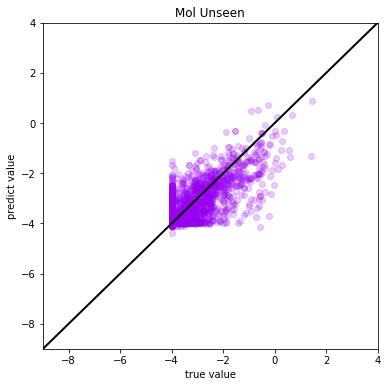

In [17]:
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

cmap = LinearSegmentedColormap.from_list("mycmap", ["#DEC0F0", "#9800F0"])
fig = plt.figure(figsize=(6, 6))
plt.xlabel("true value")
plt.ylabel("predict value")
plt.scatter(test_label, pred, alpha = 0.2, color='#9800F0')
plt.plot(range(-9,5), range(-9,5),color="black",linewidth=2)
plt.xlim(-9,4)
plt.ylim(-9,4)
plt.title("Mol Unseen")
plt.savefig(plot_path + "unseenmol_confusion_mat.svg", dpi=200)